In [1]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import accuracy
from surprise.prediction_algorithms import knns, slope_one

from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np

#### Assignment 1 solution

### Preprocessing

In [2]:
raw_interactions_df = pd.read_csv("data/RAW_interactions.csv")

In [3]:
raw_interactions_df.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [4]:
df = raw_interactions_df[['user_id', 'recipe_id', 'rating']]

In [5]:
reader = Reader(rating_scale=(0, 5))
dataset = Dataset.load_from_df(df, reader)
trainset, testset = train_test_split(dataset, test_size=0.1, random_state=42)

# Baseline Model

In [6]:
class Baseline():
    def __init__(self, df, loss=mean_squared_error):
        self.mean_rating_per_recipe = df[['recipe_id', 'rating']].groupby('recipe_id').mean()
        self.mean_rating_per_user = df[['user_id', 'rating']].groupby('user_id').mean()

        self.average_recipe_rating = self.mean_rating_per_recipe['rating'].mean()
        self.average_average_user_rating = self.mean_rating_per_user['rating'].mean()
        self.global_average_rating = df['rating'].mean()
        
        # Setting different baseline options
        self.model = 'user'
        self.model_options = {'item': self.__recipe, 
                              'user': self.__user,
                              'global': self.__global_average, 
                              'recipe_personal': self.__recipe_personal, 
                              'user_personal': self.__user_personal}
        
        # Sets loss function of model
        self.loss = loss
        
    def debug(self):
        print(self.average_recipe_rating, 
              self.average_average_user_rating, 
              self.global_average_rating)
        
    # TODO: name these methods more descriptively
    def __recipe(self, userid, reviewid):
        # returns average rating for all recipes
        return self.average_recipe_rating

    def __user(self, userid, reviewid):
        # returns average of average user ratings
        return self.average_average_user_rating

    def __global_average(self, *args):
        # returns average rating from all users
        return self.global_average_rating
    
    def __recipe_personal(self, userid, recipeid):
        # returns average rating that specific recipe recieves
        # if no data on recipe, return average recipe rating
        try:
            return self.mean_rating_per_recipe.loc[recipeid]['rating']
        except KeyError:
            return self.__recipe(userid, recipeid)
    
    def __user_personal(self, userid, recipeid):
        # returns user's average rating
        # if no data on user, return global average user rating
        try:
            return self.mean_rating_per_user.loc[userid]['rating']
        except KeyError:
            return self.__global_average(userid, recipeid)

    def prediction_on_list(self, dataset, model=None):
        if model != None:
            self.model = model            
        preds = [self.model_options[self.model](u,i) for u,i,r in dataset]
        return preds
    
    def prediction_single(self, u, i, model=None):
        if model != None:
            self.model = model
        return self.model_options[self.model](u,i)
    
    def test(self, dataset, y=None, model=None):
        # Runs single baseline
        if y is None:
            y = [r for _,_,r in dataset]
        preds = self.prediction_on_list(dataset, model)
        return self.loss(preds,y)
    
    def full_test(self, dataset):
        # Runs all baselines
        output = {}
        y = [r for _,_,r in dataset]
        for m in self.model_options:
            output[m] = self.test(dataset, y=y, model=m)
        return output

In [7]:
baseline = Baseline(df)

In [8]:
baseline.debug()

4.346246073856282 3.8730314376160444 4.411016039852804


In [9]:
baseline.full_test(testset)

{'item': 1.5934706070691902,
 'user': 1.8821862899224973,
 'global': 1.5887986777978325,
 'recipe_personal': 1.1867050474032932,
 'user_personal': 0.7036240513575874}

# SVD Model

In [10]:
# hyperparameter tuning
# best found through various trials
param_grid = {'n_factors': [1],
              'n_epochs': [14,15,16],
              'lr_all': [0.0065, 0.007, 0.0075, 0.008], 
              'reg_all': [0.06, 0.07, 0.08]}

single_train_time = 17.3
total_items = sum(len(items) for items in param_grid.values())
expected_runtime = single_train_time
for i in param_grid:
    expected_runtime = expected_runtime * len(param_grid[i])

print(f'expected runtime = {expected_runtime} seconds\nOr {expected_runtime/60} minutes')
print(f'possibly up to {expected_runtime/30} minutes?')

expected runtime = 622.8000000000001 seconds
Or 10.38 minutes
possibly up to 20.76 minutes?


In [11]:
# %%time
# gs = GridSearchCV(SVD, param_grid, measures=['mse'], cv=5, n_jobs=-1)
# gs.fit(dataset)

# # Best hyperparameters
# print(gs.best_params)

In [12]:
%%time
model = SVD(n_factors= 1, n_epochs= 15, lr_all= 0.007, reg_all= 0.07)
# model = SVD()
model.fit(trainset)

CPU times: user 4.46 s, sys: 63.6 ms, total: 4.53 s
Wall time: 4.72 s


In [13]:
predictions = model.test(trainset.build_testset())
accuracy.mse(predictions)

MSE: 1.1409


1.1408532610270905

In [14]:
predictions = model.test(testset)
accuracy.mse(predictions)

MSE: 1.4553


1.4552663171327083

#### Why is this worse?

In [15]:
users = df[['user_id', 'recipe_id']].groupby('user_id').count()
num_users_per_review_count = users.reset_index().groupby('recipe_id').count()
num_users_per_review_count.head()

,user_id
recipe_id,
1,166256
2,22738
3,9346
4,5144
5,3421


In [16]:
num_users_per_review_count['user_id'].loc[1]/users.shape[0]

0.7337952950523017

In [17]:
num_users_per_review_count['user_id'].loc[:4].sum()/users.shape[0]

0.8981065454384959

73% of the users in the dataset have only reviewed a single item so our data is extremely sparse. 90% have reviewed under 5 items

# Same analysis but only using users with >1 review

In [18]:
df_counts = df[['user_id', 'rating']].groupby('user_id').count().sort_values(by='rating', ascending=False)
users_with_multiple_reviews = set(df_counts[df_counts['rating'] > 1].index)

In [19]:
limited_df = df[df['user_id'].apply(lambda x: x in users_with_multiple_reviews)]
limited_df

,user_id,recipe_id,rating
0,38094,40893,4
1,1293707,40893,5
2,8937,44394,4
3,126440,85009,5
4,57222,85009,5
...,...,...,...
1132357,1122988,82303,5
1132361,102526,54493,0
1132363,583662,386618,5
1132364,157126,78003,5


In [20]:
reader = Reader(rating_scale=(0, 5))
dataset = Dataset.load_from_df(limited_df, reader)
limited_trainset, limited_testset = train_test_split(dataset, test_size=0.1, random_state=42)

##### Baseline

In [21]:
limited_baseline = Baseline(limited_df)

In [22]:
limited_baseline.full_test(limited_testset)

{'item': 1.1369639082176055,
 'user': 1.1905418870749,
 'global': 1.129318140440475,
 'recipe_personal': 0.8145941706410001,
 'user_personal': 0.8485871676468286}

##### Model

In [23]:
# hyperparameter tuning
# best found through various trials
#     {'mse': {'n_factors': 1, 'n_epochs': 15, 'lr_all': 0.008, 'reg_all': 0.06}}
param_grid = {'n_factors': [1],
              'n_epochs': [14,15,16],
              'lr_all': [0.0065, 0.007, 0.0075, 0.008], 
              'reg_all': [0.06, 0.07, 0.08]}

single_train_time = 17.3
total_items = sum(len(items) for items in param_grid.values())
expected_runtime = single_train_time
for i in param_grid:
    expected_runtime = expected_runtime * len(param_grid[i])

print(f'expected runtime = {expected_runtime} seconds\nOr {expected_runtime/60} minutes')
print(f'possibly up to {expected_runtime/30} minutes?')

expected runtime = 622.8000000000001 seconds
Or 10.38 minutes
possibly up to 20.76 minutes?


In [24]:
# %%time
# gs = GridSearchCV(SVD, param_grid, measures=['mse'], cv=5, n_jobs=-1)
# gs.fit(dataset)

# # Best hyperparameters
# print(gs.best_params)

In [25]:
%%time
limited_model = SVD(n_factors= 1, n_epochs= 15, lr_all= 0.0065, reg_all= 0.08)
# model = SVD()
limited_model.fit(limited_trainset)

CPU times: user 3.86 s, sys: 138 ms, total: 4 s
Wall time: 4.16 s


In [26]:
predictions = limited_model.test(limited_trainset.build_testset())
accuracy.mse(predictions)

MSE: 0.8283


0.8283305939041588

In [27]:
predictions = limited_model.test(limited_testset)
accuracy.mse(predictions)

MSE: 1.0207


1.0206542081768688

##### Trying model on non-limited data

In [28]:
limited_baseline.full_test(testset)

{'item': 1.589432132091374,
 'user': 1.606888966663602,
 'global': 1.6018533023850234,
 'recipe_personal': 1.3441734506693888,
 'user_personal': 1.3673265894950544}

In [29]:
predictions = limited_model.test(testset)
accuracy.mse(predictions)

MSE: 1.3608


1.3608064538559206

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

d = {'r_ui': [p.r_ui for p in predictions], 'est': [p.est for p in predictions], "iid":[p.iid for p in predictions], "uid":[p.uid for p in predictions]}
df = pd.DataFrame(data=d)

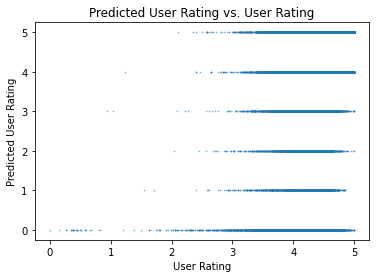

In [77]:
diff = [e-r for e,r in zip(est,r_ui)]
plt.scatter(d['est'], d['r_ui'], alpha=0.5, marker=".", s=2)
plt.ylabel('Predicted User Rating')  
plt.xlabel('User Rating')  
plt.title("Predicted User Rating vs. User Rating")
plt.savefig('Predicted_User_Rating_vs.User_Rating.png',bbox_inches="tight")

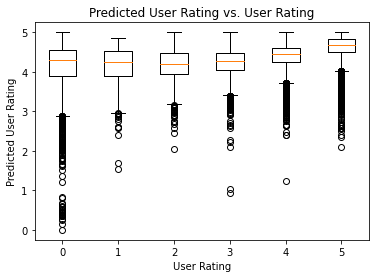

In [93]:
est_0 = df[df["r_ui"] == 0]["est"]
est_1 = df[df["r_ui"] == 1]["est"]
est_2 = df[df["r_ui"] == 2]["est"]
est_3 = df[df["r_ui"] == 3]["est"]
est_4 = df[df["r_ui"] == 4]["est"]
est_5 = df[df["r_ui"] == 5]["est"]

plt.boxplot([est_0, est_1, est_2,est_3,est_4,est_5])
plt.ylabel('Predicted User Rating')
plt.xlabel('User Rating')  
plt.xticks(ticks=range(1,7),labels=['0','1','2','3','4','5'])
plt.title("Predicted User Rating vs. User Rating")
plt.savefig('boxplot.png',bbox_inches="tight")

## Now predict the recipe a user should try

In [31]:
def find_best_recipe_for_user(userid, surprise_model, recipes_df):
    preds = [surprise_model.predict(userid,i) for i in recipes_df['id']]
    preds.sort(key=lambda p: p.est, reverse=True)  # sorts in place

    return recipes_df[recipes_df['id'] == preds[0].iid]

In [32]:
raw_recipes_df = pd.read_csv("data/RAW_recipes.csv")

In [33]:
find_best_recipe_for_user(126440, limited_model, raw_recipes_df)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
15,chicken lickin good pork chops,63986,500,14664,2003-06-06,"['weeknight', 'time-to-make', 'course', 'main-...","[105.7, 8.0, 0.0, 26.0, 5.0, 4.0, 3.0]",5,"['dredge pork chops in mixture of flour , salt...",here's and old standby i enjoy from time to ti...,"['lean pork chops', 'flour', 'salt', 'dry must...",7


In [34]:
df[df['recipe_id'] == 63986].shape[0]

19